In [1]:
import sys
sys.path.append('E:/PythonPackages')
import torch
print(torch.cuda.is_available())

True


In [2]:
import sys
sys.path.append('E:/PythonPackages')
import torch
import torchvision
import joblib
from torchsummary import summary
import random
from haar_pytorch import HaarForward, HaarInverse
import torchvision.transforms as transform
import math
import torchvision.transforms.functional as FF
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from math import log10, sqrt 
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader,Dataset,random_split
from torchvision.utils import save_image
import time
import torch.nn as nn
import torch.nn.functional as F
import cv2
import os


In [3]:

device ="cuda" if torch.cuda.is_available() else "cpu"

haar =HaarForward()
ihaar = HaarInverse()


def data_transform(img):
    tran = transform.Compose([
            transform.Resize((256,256)),
            transform.ToTensor(),
            ])
    img_tensor = tran(img).to(device)  # Move the tensor to GPU
    return img_tensor
               

               
blur_path = "D:/Desktop/GNR638/Project2/train/blurred_images/"
sharp_path = "D:/Desktop/GNR638/Project2/train/blurred_images/sharp"
batch_size = 2
classes_blur = os.listdir(blur_path)



images = []
m=0
for i in classes_blur:
    if i != "sharp" and i != "output":
        print(m)
        imgs = os.listdir(os.path.join(blur_path,i))

        for j in imgs[0:100]:
            sharp = Image.open(os.path.join(sharp_path,j))
            sharp=sharp.convert("RGB")
            sharp_image = data_transform(sharp)
            blur = Image.open(os.path.join(blur_path,i,j))
            blur_image = data_transform(blur)
            blur=blur.convert("HSV")
            hsv_img = data_transform(blur)

            inputs = torch.cat([blur_image,hsv_img],dim=0)
    
            if inputs.shape[0]==6:
                images.append((inputs,sharp_image))
        m+=1
        
        


0
1
2


In [4]:
random.shuffle(images)
train_x,test_x = images[:int(len(images)*0.8)] ,images[int(len(images)*0.8):]
print("done")

trainloader = DataLoader(train_x,batch_size=batch_size,shuffle=True)
print("done")
testloader =DataLoader(test_x,batch_size = batch_size,shuffle=False)

print("done")

done
done
done


In [5]:
sigma =nn.Sigmoid()
dropout=nn.Dropout()
class UNet(nn.Module):
    def __init__(self):
        super(UNet,self).__init__()    

        self.conv1 = nn.Conv2d(6,32,kernel_size=3,padding=1)
        self.batch1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,32,kernel_size=3,padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)
        torch.nn.init.xavier_uniform_(self.conv2.weight) 
        torch.nn.init.xavier_uniform_(self.conv1.weight) 

        self.conv3 = nn.Conv2d(128,64,kernel_size=3,padding=1)
        self.batch2 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64,64,kernel_size=3,padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)
        torch.nn.init.xavier_uniform_(self.conv4.weight) 
        torch.nn.init.xavier_uniform_(self.conv3.weight) 

        self.conv5 = nn.Conv2d(256,128,kernel_size=3,padding=1)
        self.batch3 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128,128,kernel_size=3,padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2)
        torch.nn.init.xavier_uniform_(self.conv6.weight) 
        torch.nn.init.xavier_uniform_(self.conv5.weight) 

        self.conv7 = nn.Conv2d(512,256,kernel_size=3,padding=1)
        self.batch4 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256,256,kernel_size=3,padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2,stride=2)
        torch.nn.init.xavier_uniform_(self.conv8.weight) 
        torch.nn.init.xavier_uniform_(self.conv7.weight) 
        
        self.conv9 = nn.Conv2d(1024,512,kernel_size=3,padding=1)
        self.conv10 = nn.Conv2d(512,512,kernel_size=3,padding=1)
        self.conv11 = nn.Conv2d(512,1024,kernel_size=3,padding=1)
        torch.nn.init.xavier_uniform_(self.conv11.weight) 
        torch.nn.init.xavier_uniform_(self.conv10.weight) 
        torch.nn.init.xavier_uniform_(self.conv9.weight) 


        self.upconv1 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
        self.atten1 = nn.Conv2d(256,256,kernel_size=3,padding=1)
        self.d11 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        torch.nn.init.xavier_uniform_(self.upconv1.weight) 
        torch.nn.init.xavier_uniform_(self.d11.weight)         
        torch.nn.init.xavier_uniform_(self.d12.weight)

        self.upconv2 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.atten2 = nn.Conv2d(128,128,kernel_size=3,padding=1)
        self.d21 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        torch.nn.init.xavier_uniform_(self.upconv2.weight)     
        torch.nn.init.xavier_uniform_(self.d21.weight)     
        torch.nn.init.xavier_uniform_(self.d22.weight)

        self.upconv3 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        self.atten3 = nn.Conv2d(64,64,kernel_size=3,padding=1)
        self.d31 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        torch.nn.init.xavier_uniform_(self.upconv3.weight) 
        torch.nn.init.xavier_uniform_(self.d31.weight)         
        torch.nn.init.xavier_uniform_(self.d32.weight)

        self.upconv4 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)
        self.atten4 = nn.Conv2d(32,32,kernel_size=3,padding=1)
        self.d41 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        torch.nn.init.xavier_uniform_(self.upconv4.weight) 
        torch.nn.init.xavier_uniform_(self.d41.weight)         
        torch.nn.init.xavier_uniform_(self.d42.weight)

        self.outconv = nn.Conv2d(64,3,kernel_size=1 )        
        torch.nn.init.xavier_uniform_(self.outconv.weight)
        

    def forward(self,x):
        
        x1=F.relu(self.conv1(x))
        x2=F.relu(self.conv2(x1))
        pool1=self.pool1(x2)
        pool1 = haar(pool1)

        x3=F.relu(self.conv3(pool1))
        x4=F.relu(self.conv4(x3))
        pool2=self.pool2(x4)
        pool2 = haar(pool2)

        x5=F.relu(self.conv5(pool2))
        x6=F.relu(self.conv6(x5))
        pool3=self.pool3(x6)
        pool3 = haar(pool3)

        x7=F.relu(self.conv7(pool3))
        x8=F.relu(self.conv8(x7))
        pool4=self.pool4(x8)
        pool4 = haar(pool4)

        x9=F.relu(self.conv9(pool4))
        x10=F.relu(self.conv10(x9))
        x11=sigma(self.conv11(x10))
        x11 = ihaar(x11)
    

        xu1=self.upconv1(x11)
        d= self.atten1(x8)
        x8 = x8*F.relu(d)+x8
        print(x8.shape)
        print(xu1.shape)
        xu11=torch.cat([xu1,x8],dim=1)
        xu11 = dropout(xu11) 
        xd11=sigma(self.d11(xu11))
        xd12=sigma(self.d12(xd11))
        xd12 = ihaar(xd12)
        
        xu2 = self.upconv2(xd12)
        c= self.atten2(x6)
        x6 = x6*F.relu(c)+x6
        xu22 = torch.cat([xu2, x6], dim=1)
        xu22 =dropout(xu22)
        xd21 = sigma(self.d21(xu22))
        xd22 = sigma(self.d22(xd21))
        xd22 =ihaar(xd22)

        xu3 = self.upconv3(xd22)
        b = self.atten3(x4)
        x4 = x4*F.relu(b) + x4
        xu33 = torch.cat([xu3, x4], dim=1)
        xu33 = dropout(xu33)
        xd31 = sigma(self.d31(xu33))
        xd32 = sigma(self.d32(xd31))
        xd32 = ihaar(xd32)

        xu4 = self.upconv4(xd32)
        a = self.atten4(x2)
        x2 = x2*F.relu(a) +x2
        xu44 = torch.cat([xu4, x2], dim=1)
        xu44 = dropout(xu44)
        xd41 = sigma(self.d41(xu44))
        xd42 = sigma(self.d42(xd41))
        
        x=self.outconv(xd42)
        return sigma(x)

In [6]:
model_gauss = UNet().to(device)
dummy_input = torch.randn(1, 6, 256, 256)
print(summary(model_gauss,input_size = dummy_input.shape[1:] ))
criteria=nn.MSELoss()
optimizer= optim.AdamW(model_gauss.parameters(),lr=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]           1,760
            Conv2d-2         [-1, 32, 256, 256]           9,248
         MaxPool2d-3         [-1, 32, 128, 128]               0
            Conv2d-4           [-1, 64, 64, 64]          73,792
            Conv2d-5           [-1, 64, 64, 64]          36,928
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]         295,040
            Conv2d-8          [-1, 128, 16, 16]         147,584
         MaxPool2d-9            [-1, 128, 8, 8]               0
           Conv2d-10            [-1, 256, 4, 4]       1,179,904
           Conv2d-11            [-1, 256, 4, 4]         590,080
        MaxPool2d-12            [-1, 256, 2, 2]               0
           Conv2d-13            [-1, 512, 1, 1]  

In [7]:
mae = nn.L1Loss()

def tensor_to_image(tensor):
    tensor = tensor*255
    img = transform.ToPILImage()
    return img(tensor)


In [8]:
def train(model,dataloader):

    model.train()
    running_loss=0
    m=0

    for i, data in enumerate(dataloader):
       

        blur=data[0]
        sharp=data[1]

        
        blur_image=blur.to(device)

        sharp_image = sharp.to(device)

        optimizer.zero_grad()
        outputs=model(blur_image)
        loss=criteria(outputs,sharp_image) + mae(outputs,sharp_image)

        loss.backward()

        optimizer.step()

        running_loss+=loss
        m+=1
        
    train_loss = running_loss/m
    return train_loss

In [9]:
def validate(epoch,model,dataloader):
    n=0
    model.eval()
    running_loss=0

    psnr_val = 0 

    with torch.no_grad():
        for i, data in (enumerate(dataloader)):
            
            blur=data[0]
            sharp=data[1]

            blur_image=blur.to(device)
    
            sharp_image = sharp.to(device)

    
            outputs=model(blur_image)
            loss=criteria(outputs,sharp_image)+ mae(outputs,sharp_image)
            
        
    
            outputs=outputs.detach() 
            sharp_image = sharp_image.detach() 
            save_image(outputs,f"D:/Desktop/GNR638/Project2/train/blurred_images/output/{epoch}_blur.jpg")
            save_image(sharp_image,f"D:/Desktop/GNR638/Project2/train/blurred_images/output/{epoch}_sharp.jpg")
            img1 = cv2.imread(f"D:/Desktop/GNR638/Project2/train/blurred_images/output/{epoch}_blur.jpg")
            img2 = cv2.imread(f"D:/Desktop/GNR638/Project2/train/blurred_images/output/{epoch}_sharp.jpg")
            running_loss+=loss.item()
    
            psnr_val +=cv2.PSNR(img1,img2)
            n+=1
          
        
            

    val_loss=running_loss/n
    
    return val_loss,psnr_val/n


In [10]:
file = open("new_data.txt","w")

train_loss  = []
val_loss   = []
psnr_values = []
start=time.time()


In [11]:
# Define function to plot training curves
def plot_training_curves(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    epochs = np.arange(len(train_losses))
    plt.plot(epochs, train_losses, color="red", label='Train Loss')
    plt.plot(epochs, val_losses, color="blue", label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss Curves")
    plt.show()

# Define function to plot PSNR curve
def plot_psnr_curve(psnr_values):
    plt.figure(figsize=(10, 5))
    epochs = np.arange(len(psnr_values))
    plt.plot(epochs, psnr_values, color="green", label='PSNR')
    plt.xlabel("Epoch")
    plt.ylabel("PSNR")
    plt.legend()
    plt.title("PSNR Curve")
    plt.show()

In [12]:

for epoch in range(0,100):
    
    train_epoch = train(model_gauss,trainloader)
    val_epoch,psnr_val = validate(epoch,model_gauss,testloader)
    train_loss.append(float(train_epoch))
    val_loss.append(float(val_epoch))
    psnr_values.append(float(psnr_val))
    scheduler.step(val_epoch)

    file.write(f"Epoch:{epoch} Training_loss:{train_epoch} Validation_loss:{val_epoch} Avg PSNR_Val = {psnr_val}\n")
    print(f"Epoch:{epoch} Training_loss:{train_epoch} Validation_loss:{val_epoch} Avg PSNR_Val = {psnr_val}")

         

file.close()

end=time.time()

torch.save(model_gauss,"D:/Desktop/GNR638/Project2/train/blurred_images/new_data.pt")


torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
t

e:\myenv\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch:0 Training_loss:0.1052471250295639 Validation_loss:0.07466525534788768 Avg PSNR_Val = 21.090872848717947
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4])
torch.Size([2, 256, 4, 4]

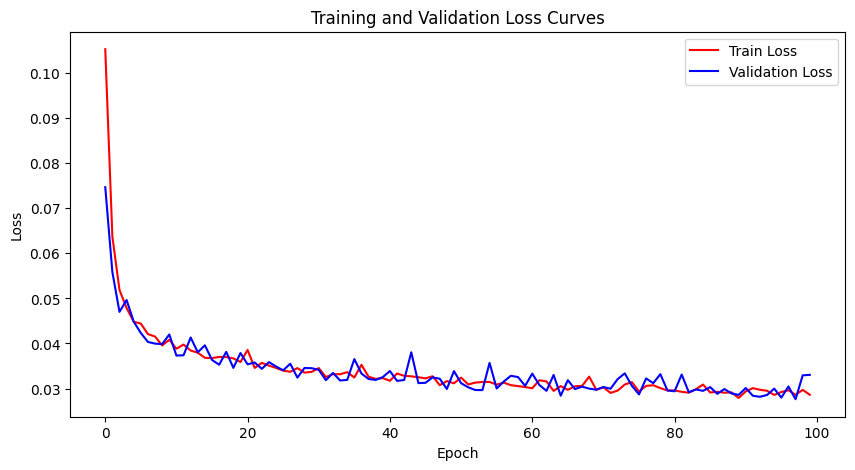

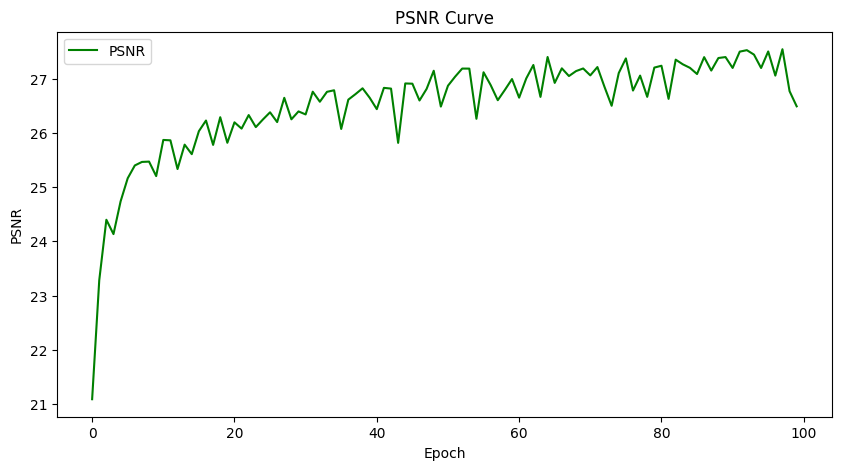

In [14]:
# Plot training and validation curves
plot_training_curves(train_loss, val_loss)

# Plot PSNR curve
plot_psnr_curve(psnr_values)

In [15]:
max_psnr = max(psnr_values)
print("Maximum PSNR:", max_psnr)

min_train_loss = min(train_loss)
print("Minimum Train Loss:", min_train_loss)

min_val_loss = min(val_loss)
print("Minimum Validation Loss:", min_val_loss)

Maximum PSNR: 27.53953346217939
Minimum Train Loss: 0.02792118303477764
Minimum Validation Loss: 0.027643241609136265
